# Análise sobre acumulação de Erro via sensor de Nav. Inercial
   
<img src= "EulerGyro-Phi.png" width ="500">
<img src= "EulerGyro-Theta.png" width ="500">
<img src= "EulerGyro-Psi.png" width ="500">


## Declaração das Funções-Membro necessárias para o Exemplo 

 ## Desenvolvimento TestGyro.py

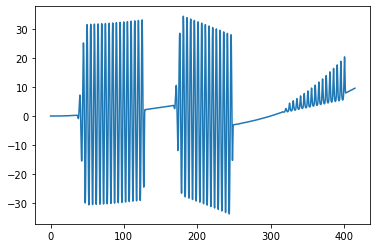

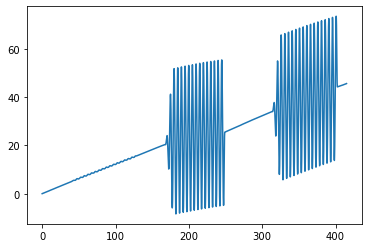

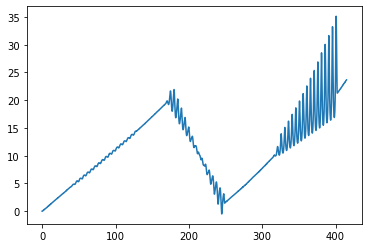

In [34]:
# Declaring Initial Vars
Nsamples = 41500
dt = 0.01
ang_vel = [0, 0, 0]

# Instantiate arrays to plot afterwards
t = [x*dt for x in range(Nsamples)]
EulerSaved = np.zeros((3, Nsamples))

# Instantiate Iterators
EulerGyro = Gyro()
Radius = iter(EulerGyro.GetGyro("ArsGyro.csv"))


for k in range(Nsamples):

    newRadius = next(Radius)
    phi, theta, psi = EulerGyro.EulerGyro(newRadius, dt)
    EulerSaved[:, k] = phi, theta, psi

PhiSaved   = [(x*180 / pi) for x in EulerSaved[0]]
ThetaSaved = [(x*180 / pi) for x in EulerSaved[1]]
PsiSaved   = [(x*180 / pi) for x in EulerSaved[2]]


plot_1, xt = plot.subplots()
plot_2, yt = plot.subplots()
plot_3, zt = plot.subplots()

xt.plot(t,PhiSaved, '-', label="eixo = x", markersize=0.5)
yt.plot(t,ThetaSaved, '-', label="eixo = y", markersize=0.5)
zt.plot(t,PsiSaved, '-', label="eixo = y", markersize=0.5)
plot.show()



 ## Desenvolvimento TestAccel.py

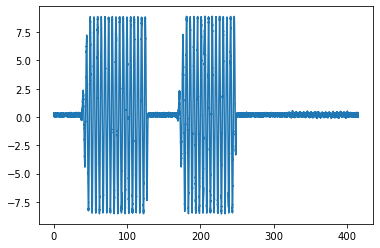

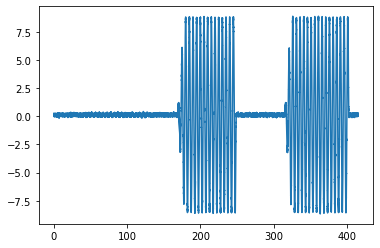

In [33]:
# Instantiate Iterators
EulerAccel = Gyro()
Radius = iter(EulerGyro.GetGyro("ArsAccel.csv"))

# Instantiate arrays to plot afterwards
t = [x*dt for x in range(Nsamples)]
EulerSaved = np.zeros((2, Nsamples))


for k in range(Nsamples):
    x, y = next(Radius)
    phi, theta = EulerAccel.EulerAccel(x, y)
    EulerSaved[:, k] = phi, theta
PhiSaved   = [(x * 180 / pi) for x in EulerSaved[0]]
ThetaSaved = [(x * 180 / pi) for x in EulerSaved[1]]


plot_1, xt = plot.subplots()
plot_2, yt = plot.subplots()

xt.plot(t, PhiSaved, '-', label="eixo = x", markersize=0.5)
yt.plot(t, ThetaSaved, '-', label="eixo = y", markersize=0.5)

plot.show()

### Classe Gyro

In [7]:
import csv
from math import cos, sin, tan, pi, asin
import matplotlib.pyplot as plot
import numpy as np

class Gyro:
    def __init__(self):
        self.prev_angles = [0, 0, 0]
    
    def GetGyro(self, filename):
        with open(filename) as file:
            data = csv.reader(file)
            for line in data:
                line = [float(x) for x in line]
                yield line

    def EulerGyro(self, R, delta):
        p_phi, p_theta, p_psi = self.prev_angles

        phi = p_phi     + delta * (R[0] + R[1]*sin(p_phi) * tan(p_theta) + R[2] * cos(p_phi) * tan(p_theta))
        theta = p_theta + delta * (       R[1]*cos(p_phi)                - R[2] * sin(p_phi))
        psi = p_psi     + delta * (       R[1]*sin(p_phi)/cos(p_theta)   + R[2] * cos(p_phi) / cos(p_theta))
        self.prev_angles = phi,theta,psi
        return [phi, theta, psi]
    
    def EulerAccel(self, ax=0, ay=0):
        g = 9.8
        Theta = asin(ax/g)
        Phi = asin(-ay/(g*cos(theta)))
        return Phi, Theta

    def EulerToQuaternion(self, u, v, w):
        z = np.zeros((4, 1))
        Phi   = u/2
        Theta = v/2
        Psi   = w/2
        z[0, 0] = cos(Phi)*cos(Theta)*cos(Psi)+sin(Phi)*sin(Theta)*sin(Psi)
        z[1, 0] = sin(Phi)*cos(Theta)*cos(Psi)-cos(Phi)*cos(Theta)*sin(Psi)
        z[2, 0] = cos(Phi)*sin(Theta)*cos(Psi)+sin(Phi)*sin(Theta)*sin(Psi)
        z[3, 0] = cos(Phi)*cos(Theta)*sin(Psi)-sin(Phi)*sin(Theta)*cos(Psi)

        return z

    
    

### Classe KalmanTools

In [5]:
import numpy as np 
from math import atan2, asin

class KalmanFilter(object):
	def __init__(self):
		#initial Variables
		self.A = np.matrix
		self.H = np.matrix
		self.Q = np.matrix
		self.R = np.matrix
		self.x = np.matrix
		self.P = np.matrix
		self.dt : float
		self.z = np.matrix
		self.K = np.matrix

	def setTransitionMatrix(self, A):
		self.A = A
        
	def setSttMeasure(self, H):
		self.H = H

	def setSttVariable(self, x):
		self.x = x

	def setTransitionCovMatrix(self, Q):
		self.Q = Q

	def setMeasureCovMatrix(self, R):
		self.R = R

	def setDeltaT(self, delta):
		self.dt = delta

	def setErrorCovMatrix(self, P):
		self.P = P

	def filter(self, A, z):
		self.z = z
		xp = A * self.x
		Pp = A * self.P * A.getT() + self.Q
		self.K = Pp * self.H.getT() * np.matrix.getI(self.H * Pp * self.H.getT() + self.R)
		self.x = xp + self.K * (self.z - self.H * xp)
		self.P = Pp - self.K * self.H * Pp

		x1 = self.x[0, 0]
		x2 = self.x[1, 0]
		x3 = self.x[2, 0]
		x4 = self.x[3, 0]

		phi   =  atan2(2*(x3*x4 + x1*x2), 1 - 2*(x2**2+x3**2))
		theta = -asin( 2*(x2*x4 - x1*x3))
		psi   =  atan2(2*(x2*x3 + x1*x4), 1 - 2*(x3**2+x4**2))

		return phi, theta, psi


### Execução do Algoritmo

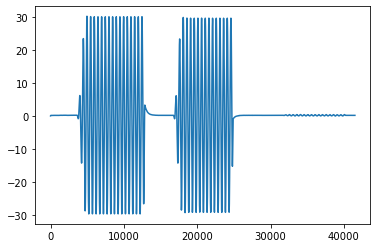

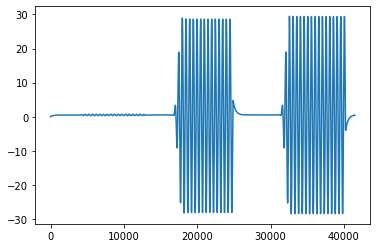

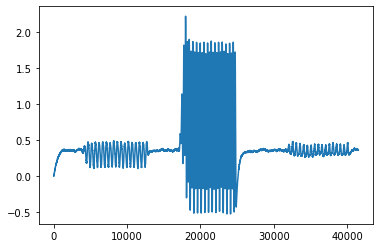

In [6]:
import csv
from math import cos, sin, tan, asin, pi
import KalmanTools as Tools
import matplotlib.pyplot as plot

import numpy as np

class Gyro:
    def __init__(self):
        self.prev_angles = [0, 0, 0]
        self.Kalman_prev_angles = [0, 0, 0]
        


    def GetGyro(self, filename):
        with open(filename) as file:
            data = csv.reader(file)
            for line in data:
                line = [float(x) for x in line]
                yield line

    def EulerGyro(self, R, delta):
        p_phi, p_theta, p_psi = self.prev_angles

        Phi = p_phi + delta * (R[0] + R[1] * sin(p_phi) * tan(p_theta) + R[2] * cos(p_phi) * tan(p_theta))
        Theta = p_theta + delta * (R[1] * cos(p_phi) - R[2] * sin(p_phi))
        Psi = p_psi + delta * (R[1] * sin(p_phi) / cos(p_theta) + R[2] * cos(p_phi) / cos(p_theta))
        self.prev_angles = phi, theta, psi
        return [Phi, Theta, Psi]

    def EulerAccel(self, ax, ay):
        g = 9.8
        theta = asin(ax / g)
        phi = asin(-ay / (g * cos(theta)))
        return phi, theta

    def EulerToQuaternion(self, u, v, w):
        z = np.zeros((4, 1))

        Phi   = u / 2
        Theta = v / 2
        Psi   = w / 2

        z[0, 0] = cos(Phi)*cos(Theta)*cos(Psi)+sin(Phi)*sin(Theta)*sin(Psi)
        z[1, 0] = sin(Phi)*cos(Theta)*cos(Psi)-cos(Phi)*cos(Theta)*sin(Psi)
        z[2, 0] = cos(Phi)*sin(Theta)*cos(Psi)+sin(Phi)*sin(Theta)*sin(Psi)
        z[3, 0] = cos(Phi)*cos(Theta)*sin(Psi)-sin(Phi)*sin(Theta)*cos(Psi)

        return z


#Instantiate Objects
EulerGyro = Gyro()
Radius = iter(EulerGyro.GetGyro("ArsGyro.csv"))
Accel = iter(EulerGyro.GetGyro("ArsAccel.csv"))


# Declare Initial Variables and Matrix
Nsamples = 41500
dt = 0.01
t = [x for x in range(Nsamples)]
EulerSaved = np.zeros((3, Nsamples))

H = np.asmatrix(np.eye(4))
Q = np.asmatrix(np.eye(4)*0.0001)
R = np.asmatrix(np.eye(4)*10)

x = np.matrix([[1, 0, 0, 0]]).getT()
P = np.asmatrix(np.eye(4)*1.0)

# Instantiate object Kalman Tools and initial data
EulerKalman = Tools.KalmanFilter()
EulerKalman.setTransitionCovMatrix(Q)
EulerKalman.setMeasureCovMatrix(R)
EulerKalman.setSttMeasure(H)
EulerKalman.setErrorCovMatrix(P)
EulerKalman.setSttVariable(x)
EulerKalman.setDeltaT(dt)

for k in range(Nsamples):
    p, q, r = next(Radius)

    ax, ay = next(Accel)
    aux = np.matrix([[0, -p, -q, -r],
                    [p,  0.,  r, -q],
                    [q,  -r,  0,  p],
                    [r,   q, -p,  0]])
    A = np.asmatrix(np.eye(4)) + aux*dt*0.5

    phi, theta = EulerGyro.EulerAccel(ax,ay)
    z = EulerGyro.EulerToQuaternion(phi, theta, 0)
    phi, theta, psi = EulerKalman.filter(A, z)
    EulerSaved[:, k] = phi, theta, psi

PhiSaved   = [(x*180 / pi) for x in EulerSaved[0]]
ThetaSaved = [(x*180 / pi) for x in EulerSaved[1]]
PsiSaved   = [(x*180 / pi) for x in EulerSaved[2]]


plot1, plot_phi = plot.subplots()
plot2, plot_theta = plot.subplots()
plot3, plot_psi = plot.subplots()


plot_phi.plot(t, PhiSaved, '-', label="eixo = x", markersize=0.5)
plot_theta.plot(t, ThetaSaved, '-', label="eixo = y", markersize=0.5)
plot_psi.plot(t, PsiSaved,'-', label="eixo = z", markersize=0.5)

plot.show()



# DPC++ implementation

In [178]:
%%writefile EulerKalman.cpp
#include <iostream>
using std::cout;
using std::endl;

#include <vector>
using std::vector; 

#include <fstream>
using std::ifstream; 
using std::ofstream; 


#include <stdlib.h>
#include <string>
using std::stof;
using std::string;

#include <limits>
#include <random>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"
namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;

#include "KalmanTools.h"


// Struct to store measures (x,y):
struct Gyro
{
	long double coord_x;
	long double coord_y;
	long double coord_z;
};


//Function Prototype
Gyro *GetRead(string filename, int Samples);
void eye(double* A, int l, double a );
void zero(double* A, int l, int m);
void AdjustMatrix(double *,double, double,double,double);
void EulerToQuaternion(double *, double, double, double);
void EulerAccel(double, double, double &ax, double &ay);

int main(){
    //create file : EulerKalman.csv
    ofstream myfile("EulerSaved.csv");
    myfile << "time,Phisaved,Thetasaved,Psisaved\n";
    auto async_handler = [](sycl::exception_list exceptions) {
        for (exception_ptr const &e : exceptions) {
            try {
                rethrow_exception(e);
            }
            catch (sycl::exception const &e) {
                cout << "Caught asynchronous SYCL exception: " << e.what() << endl;
            }
        }
    };
    
    try {
        
         
        //About Accelerator Device & Queue
        sycl::device device = sycl::device(sycl::default_selector());
        cout << "Device: " << device.get_info<sycl::info::device::name>() << "\n";
        sycl::queue queue(device, async_handler);
        vector<sycl::event> event_list;
        
        
        
        //Declare example variables, lists and Kalman Object
        double dt = 0.01;
        const int Nsamples = 41500;
        double t[Nsamples];

        auto *Phisaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *Psisaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *Thetasaved = sycl::malloc_shared<double>(Nsamples, queue);
        
        
        
        auto *A = sycl::malloc_shared<double>(4 * 4, queue);
        zero(A,4,4);
        auto *H = sycl::malloc_shared<double>(4 * 4, queue);
        eye(H, 4, 1.0);
        
        auto *Q = sycl::malloc_shared<double>(4 * 4, queue);
        eye(Q, 4, 0.0001);
        
        auto *R = sycl::malloc_shared<double>(4 * 4, queue);
        eye(R, 4, 10.0);
        
        auto *x = sycl::malloc_shared<double>(4 * 1, queue);
        x[0] = 1; x[1] = 0; x[2]  = 0; x[3] = 0;     
        
        auto *P = sycl::malloc_shared<double>(4 * 4, queue);
        eye(P, 4, 1.0);
        
        auto *z = sycl::malloc_shared<double>(4 * 1, queue);
        
        Kalman_filter *kalman = new Kalman_filter();
        kalman->setTransitionCovMatrix(Q);
        kalman->setMeasureCovMatrix(R);
        kalman->setSttMeasure(H);
        kalman->setErrorCovMatrix(P);
        kalman->setSttVariable(x);
        kalman->setDeltaT(dt);
        
        
        //generate list with Coordinate measures
        Gyro *Radius = GetRead("ArsGyro.csv", Nsamples);
        Gyro *angular_accel = GetRead("ArsAccel.csv", Nsamples);
        
        
        if (!Phisaved || !Psisaved || !Thetasaved) {
            cerr << "Could not allocate memory for vectors." << endl;
            exit(1);
        }
        
        int first = 0;
        double p, q, r , ax, ay, phi, theta, psi;
        for (int i = 0; i < Nsamples; i++){  
            //Get values from Gyro Struct and define t array
            t[i] = i*dt;
            
            p = Radius[i].coord_x;
            q = Radius[i].coord_y;
            r = Radius[i].coord_z;
            
            ax = angular_accel[i].coord_x;
            ay = angular_accel[i].coord_y;
            
            AdjustMatrix(A, p, q, r, dt);
            //These values are returned in ax and ay.
            EulerAccel(ax,ay, phi, theta); 
            EulerToQuaternion(z, phi, theta, 0);
            
            kalman->filter(A,z);
            phi = kalman->get_phi();
            theta = kalman->get_theta();
            psi = kalman->get_psi();
            
            //calculate, then store on arrays
            phi   = phi*180/3.141592;
            theta = theta*180/3.141592;
            psi   = psi*180/3.141592;
            Phisaved[i]   = psi; 
            Thetasaved[i] = theta;
            Psisaved[i]   = psi;
            //Save the results below in myfile. 
            myfile << t[i] <<", "<< phi << ", " << theta << ", " << psi <<'\n';
        }
        myfile.close();
        free(Phisaved, queue);
        free(Psisaved, queue);
        free(Thetasaved, queue);
        //kalman->end_task();

    } catch (const exception &e) {
        cerr << "An exception occurred: "
                  << e.what() << endl;
        exit(1);
    }
}



Gyro *GetRead(string filename, int Samples){
	
	ifstream file;
	file.open(filename);
	Gyro *L = new Gyro[Samples];
	if(file.is_open()){
		string buff, out_x, out_y,out_z;
		size_t pos_1, pos_2;
		int it = 0;
		cout << "reading doc.: " << filename;

		while(getline(file, buff)){;
			pos_1 = buff.find(",");
			pos_2 = buff.rfind(",");
			// Essa condicao serve para leitura de ambos os arquivos
			if(pos_1 != pos_2){
				L[it].coord_x = stold(buff.substr(0,pos_1));
				L[it].coord_y = stold(buff.substr(1+pos_1, pos_2-pos_1));
				L[it].coord_z = stold(buff.substr(1+pos_2));
			} else { 
				//Condicao para leitura do Arq. ArsAccel.csv
				L[it].coord_x = stold(buff.substr(0,pos_1));
				L[it].coord_y = stold(buff.substr(1+pos_1));

			}
			it++;
		}
		cout << ": OK! " << endl;
	} else {
		cout << "Error : Could not read !!" <<endl;
        L = nullptr;
	}
	return L;

}

void eye(double* A, int l, double val){
	for(int i =0; i < l; i++){
		for(int j=0; j<l; j++){
			if(i == j) A[j+i*l] = val;
			else A[j+i*l] = 0.0;
		}
	}
}
void zero(double* A, int l, int m){
	for(int i =0; i < l; i++){
		for(int j=0; j<m; j++){
			A[j+i*l] = 0.0;
		}
	}
}


void EulerToQuaternion(double *z, double u, double v, double w){
	
	double Phi, Theta, Psi;

	Phi   = u / 2;
    Theta = v / 2;
    Psi   = w / 2;
    z[0] = cos(Phi)*cos(Theta)*cos(Psi)+sin(Phi)*sin(Theta)*sin(Psi);
    z[1] = sin(Phi)*cos(Theta)*cos(Psi)-cos(Phi)*cos(Theta)*sin(Psi);
    z[2] = cos(Phi)*sin(Theta)*cos(Psi)+sin(Phi)*sin(Theta)*sin(Psi);
    z[3] = cos(Phi)*cos(Theta)*sin(Psi)-sin(Phi)*sin(Theta)*cos(Psi);	    
}


void EulerAccel(double ax, double ay, double &p,double &t){
	double g = 9.8;
    
	t = asin(ax / g);
	p = asin(-ay / (g * cos(ax)));


}


void AdjustMatrix(double *aux,double p, double q, double r, double dt){
	aux[0] = 0; aux[1] =-p; aux[2] =-q; aux[3] =-r;
	aux[4] = p; aux[5] = 0; aux[6] = r; aux[7] =-q;
	aux[8] = q; aux[9] =-r; aux[10]= 0; aux[11]= p;
	aux[12]= r; aux[13]= q; aux[14]=-p; aux[15]= 0;
	for(int i =0; i <4; i++) {
		for(int j=0; j < 4; j++){
			aux[j+4*i] = aux[j+4*i]*0.5*dt;
			if(i==j) aux[j+4*i]+= 1;
		}
	}
}

Overwriting EulerKalman.cpp


# KalmanTools Class Implementation (DPC++)

In [179]:
%%writefile KalmanTools.h


#include <iostream>
#include <cmath>
#include <fstream>
#include <stdlib.h>
#include <stdio.h>
#include <limits>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"

#include <algorithm> 

#include <iomanip>
using std::setw;

namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;
using namespace std;

auto nontransM = oneapi::mkl::transpose::nontrans;
auto    transM = oneapi::mkl::transpose::trans;

void inv(sycl::queue &queue, double *A, int64_t N) {
    sycl::event getr_task[2];
    vector<sycl::event> event_list;

    double scratch_size = lapack::getrf_scratchpad_size<double>(queue, N, N, N);
    double *scratchpad = sycl::malloc_shared<double>(scratch_size+1, queue);

    auto *IPIV = sycl::malloc_shared<int64_t>(N*N, queue);
    
    getr_task[0] = lapack::getrf(queue, N, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[0].wait();
    getr_task[1] = lapack::getri(queue, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[1].wait();
    
    free(IPIV, queue);
}
class Kalman_filter {
private: 
    sycl::queue queue;
    double alpha = 1.0; 
    double beta = 0.0;
    int M = 4;
    int N = 2;
    int L = 1; 
    double dt;
    
    const int size_1 = N*N;
    const int size_2 = M*N;
    const int size_3 = M*M;
    
    const int size_4 = M*L;

    //Matrix Pointers
    double *A;
    double *H;
    double *Q;
    double *R;
    double *x;
    double *P;
    double *z;


    // Intermediary values to calculus
    double *xp    = sycl::malloc_shared<double>(M * L, queue);
    double *Pp    = sycl::malloc_shared<double>(M * M, queue);
    double *K     = sycl::malloc_shared<double>(M * M, queue);
    double *AP    = sycl::malloc_shared<double>(M * M, queue);   
    double *PpHT  = sycl::malloc_shared<double>(M * M, queue); 
    double *HpHTR = sycl::malloc_shared<double>(M * M, queue);
    double *Hxp   = sycl::malloc_shared<double>(M * L, queue);
    double *KH    = sycl::malloc_shared<double>(M * M, queue); 

public: 
    //modules
    void filter(double *,double *);
    double getResult(int row, int col);
    
   void setDeltaT( double setdt );
    void setTransitionMatrix(double *Aset);
    void setSttMeasure(double * Hset);
    void setSttVariable(double * xset);
    void setTransitionCovMatrix(double * Qset);
    void setMeasureCovMatrix(double * Rset);
    void setErrorCovMatrix(double * P);
    double get_phi();
    double get_theta();
    double get_psi();
    void end_task();
};



void Kalman_filter::setDeltaT( double setdt ){
    dt = setdt;
}

void Kalman_filter::setTransitionMatrix(double *Aset){
    A = Aset;
}

void Kalman_filter::setSttMeasure(double * Hset){
    H = Hset;
}

void Kalman_filter::setSttVariable(double * xset){
    x = xset;    
}

void Kalman_filter::setTransitionCovMatrix(double * Qset){
    Q = Qset;
}

void Kalman_filter::setMeasureCovMatrix(double * Rset){
    R = Rset;
}

void Kalman_filter::setErrorCovMatrix(double * Pset){
    P = Pset;
}      

double Kalman_filter::get_phi(){
    double x1,x2,x3,x4;
    x1 = x[0]; x2 = x[1];
    x3 = x[2]; x4 = x[3];
    
    double phi = atan2(2*(x3*x4 + x1*x2), 1 - 2*(x2*x2+x3*x3));
    return phi;
}      
double Kalman_filter::get_theta(){
    double x1,x2,x3,x4;
    x1 = x[0]; x2 = x[1];
    x3 = x[2]; x4 = x[3];
    
    double theta = -asin( 2*(x2*x4 - x1*x3));
    return theta;
}      
double Kalman_filter::get_psi(){
    double x1,x2,x3,x4;
    x1 = x[0]; x2 = x[1];
    x3 = x[2]; x4 = x[3];
    
    double psi   =  atan2(2*(x2*x3 + x1*x4), 1 - 2*(x3*x3+x4*x4));
    return psi;
}      


void Kalman_filter::filter(double *A_input,double *z_input){
    z = z_input;
    setTransitionMatrix(A_input); 
    
    constexpr int gemm_total = 10, axpy_total = 5;
    sycl::event gemm_task[gemm_total], scal_task;
    sycl::event axpy_task[axpy_total];
    vector<sycl::event> gemm[gemm_total];
       
     // xp(MxL) = A(MxM) * x(MxL) 
    gemm_task[0] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, M, alpha, A, M, x, L, beta, xp, L, gemm[0]);
    gemm_task[0].wait();
       
    
     // Pp(MxM) = A * P * A' + Q(MxM) 
        //1.1) AP(MxM) = A(MxM) * P(MxM)
    gemm_task[1] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, A, M, P, M, beta, AP, M, gemm[1]);
    gemm_task[1].wait();
       
        //1.2) Pp = AP(MxM) * A'(MxM) 
    gemm_task[2] = blas::row_major::gemm(queue, nontransM, transM, M, M, M, alpha, AP, M, A, M, beta, Pp, M, gemm[2]);
    gemm_task[2].wait();
    
    
        //1.3) Pp(MxM) = Pp(MxM) + Q(MxM)  
    axpy_task[0] = blas::axpy(queue, M*M, alpha, Q, 1.0, Pp, 1.0);
    axpy_task[0].wait();
    
    
    // K = Pp * H' * inv(H * Pp * H' + R)
        // 2.1) PpHT(MxM) = Pp(MxM) * Ht(MxM) 
    gemm_task[3] = blas::row_major::gemm(queue, nontransM, transM, M, M, M, alpha, Pp, M, H, M, beta, PpHT, M, gemm[3]);
    gemm_task[3].wait();

        // 2.2) HpHTR(NxN) = H(MxM) * [ Pp(MxM) * Ht(MxM) ] = H (MxM) * PpHT(MxM) 
    gemm_task[4] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, H, M, PpHT, M, beta, HpHTR, M, gemm[4]);
    gemm_task[4].wait();

                                       
        // 2.3) HpHTR(MxM) = HpHTR(MxM) + R(MxM)
    axpy_task[1] = blas::axpy(queue, M*M, alpha, R, 1.0, HpHTR, 1.0);
    axpy_task[1].wait();

    
        // HpHTR(MxM) = inv(HpHTR)
    inv(queue, HpHTR, M);                                
    
         // 2.4) K(MxM) = (Pp(MxM) * Ht(MxM)) * HpHTR(MxM) -> PpHT(MxM) * HpHTR(MxM) 
    gemm_task[5] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, PpHT, M, HpHTR, M, beta, K, M, gemm[5]);
    gemm_task[5].wait();
    
    
    
    
        // x(MxK) = xp(MxK) + K * (z - H * xp)
        // 3.1) Hxp(MxL) = H(MxM) * xp(MxL)
    gemm_task[6] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, M, alpha, H, M, xp, L, beta, Hxp, L, gemm[6]);
    gemm_task[6].wait();
    

    
        // 3.2) z(MxL) = -Hxp(MxL) + z(MxL)
    axpy_task[2] = blas::axpy(queue, M*L, -alpha, Hxp, 1.0, z, 1.0);
    axpy_task[2].wait();    
    
        //3.3) // x(MxL) = K(MxM)*z(MxL)
    gemm_task[7] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, M, alpha, K, M, z, L, beta, x, L, gemm[7]);
    gemm_task[7].wait();
    
        //3.4) x(MxL) = xp(MxL) + x(MxL)
    axpy_task[3] = blas::axpy(queue, M*L, alpha, xp, 1.0, x, 1.0);
    axpy_task[3].wait();
    
    // P = Pp - K * H * Pp
        //4.1) KH(MxM) = K(MxM)*H(MxM)
    gemm_task[8] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, K, M, H, M, beta, KH, M, gemm[8]);
    gemm_task[8].wait();

        //4.2) P(MxM) =(-1)* KH(MxM) * Pp(MxM) 
    gemm_task[9] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, -alpha, KH, M, Pp, M, beta, P, M, gemm[9]);
    gemm_task[9].wait();
    
        //4.3) P(MxM) = (Pp - P) 
    axpy_task[4] = blas::axpy(queue, M * M, alpha, Pp, 1.0, P, 1.0);
    axpy_task[4].wait();
    


    //End calculus here, then its necessary to acess it by GetResult, 
    //which is obtained by the matrix X(nRow x nCol).
    
    
}    



/*
void end_task(){
    free(A, queue);
    free(H, queue);
    free(Q, queue);
    free(R, queue);
    free(x, queue);
    free(P, queue);
    free(z, queue);

    free(xp, queue);
    free(Pp, queue);
    free(K, queue);
    free(AP, queue);
    free(PpHT, queue);
    free(HpHTR, queue);
    free(Hxp, queue);
    free(Kz, queue);
    free(KH, queue);
    
}
*/



Overwriting KalmanTools.h


# CPU execution

dpcpp EulerKalman.cpp -o EulerKalman -DMKL_ILP64  -I"/glob/development-tools/versions/oneapi/2021.4/inteloneapi/mkl/2021.4.0/include" -fsycl-device-code-split=per_kernel -L/glob/development-tools/versions/oneapi/2021.4/inteloneapi/mkl/2021.4.0/lib/intel64 -lmkl_sycl -lmkl_intel_ilp64 -lmkl_sequential -lmkl_core -lsycl -lOpenCL -lpthread -lm -ldl
./EulerKalman
Device: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
reading doc.: ArsGyro.csv: OK! 
reading doc.: ArsAccel.csv: OK! 


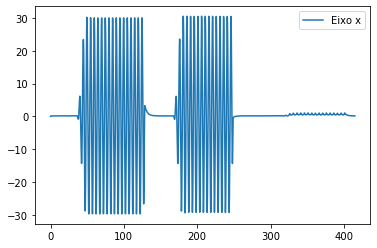

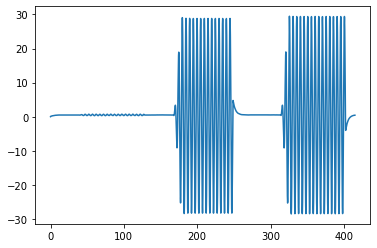

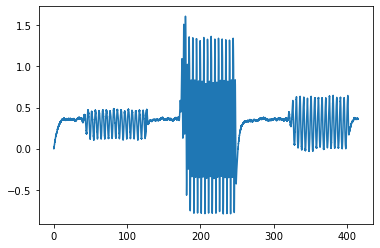

In [180]:
! make 
! mv EulerSaved.csv EulerKalmanCPU.csv
import matplotlib.pyplot as plt
import pandas as pd


def plot_results(filename):
    df = pd.read_csv(filename)
    
    plot_1, ax = plt.subplots()
    plot_2, ay = plt.subplots()
    plot_3, az = plt.subplots()

    ax.plot(df.time.to_list(), df.Phisaved.to_list(), '-', label="Eixo x")
    ay.plot(df.time.to_list(), df.Thetasaved.to_list(), '-', label="Eixo y")
    az.plot(df.time.to_list(), df.Psisaved.to_list(), '-', label="Eixo z")
    
    #ax.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")
    #ax.set(title="Position Label", xlabel="Horizontal [Pixels]", ylabel="Vertical [Pixels]")
    ax.legend()

plot_results('EulerKalmanCPU.csv')


# GPU execution

In [ ]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi
! mv EulerKalman.csv EulerKalmanGPU.csv

plot_results('EulerKalmanGPU.csv')

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
992440.v-qsvr-1            ...ub-singleuser u81855          00:20:05 R jupyterhub     
992469.v-qsvr-1            build_run.sh     u81855                 0 Q batch          

Waiting for Output ██████████████████